In [203]:
# Important remark
# This script compares two files and shows the differences between them.
# More precisely: It compares a worse one (with some accuracy loss) to a ground truth data series.

In [204]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [205]:
base_dir = os.getcwd()
pattern = re.compile(r"result_(cen|fed)_(\d+)\.csv")
datasets = {}
for fname in os.listdir(base_dir):
    match = pattern.match(fname)
    if match:
        typ, num = match.groups()
        key = f"set_{num}"
        if key not in datasets:
            datasets[key] = {}
        datasets[key][typ] = pd.read_csv(os.path.join(base_dir, fname))

# Example: access datasets["set_01"]["cen"] or datasets["set_01"]["fed"]
print(f"Loaded {len(datasets)} dataset pairs.")

datasets = dict(sorted(datasets.items(), key=lambda x: int(x[0].split('_')[1])))

print(f"Datasets sorted by key: {list(datasets.keys())}")



Loaded 8 dataset pairs.
Datasets sorted by key: ['set_2132', 'set_4264', 'set_8528', 'set_17056', 'set_34112', 'set_68224', 'set_136448', 'set_272896']


In [214]:
#read file test.csv
rel_errors_list = []


for key, data_pair in datasets.items():
    #print(f"Processing dataset pair: {key}")
    df_cen = data_pair["cen"]
    df_fed = data_pair["fed"]
    # print(f"Dataset: {key}")
    # print("Centralized Data Head:")
    # print(df_cen.head())
    # print("Federated Data Head:")
    # print(df_fed.head())
    # print("\n")

    df_cen["timestamp"] = pd.to_datetime(df_cen["timestamp"], format="mixed").dt.strftime("%H:%M:%S")

    df_fed["timestamp"] = pd.to_datetime(df_fed["timestamp"], format="mixed").dt.strftime("%H:%M:%S")
    
    #Align datasets to the same (or most similar) starting value on rank 1

    # 1. Determine the rankcount
    try:
        # Assuming rankcount is consistent and starts from 1
        rankcount = df_cen['rank'].max()
        if rankcount != df_fed['rank'].max():
            print(f"Warning: Mismatched max rank for {key}. Using cen max rank: {rankcount}")
    except Exception as e:
        print(f"Error determining rankcount for {key}: {e}. Skipping.")
        continue

    # 2. Isolate all rank 1 frequencies for comparison
    cen_rank1_freqs = df_cen[df_cen['rank'] == 1]['estimated_frequency'].reset_index(drop=True)
    fed_rank1_freqs = df_fed[df_fed['rank'] == 1]['estimated_frequency'].reset_index(drop=True)

    if cen_rank1_freqs.empty or fed_rank1_freqs.empty:
        print(f"Warning: No rank 1 data found for comparison in {key}. Skipping.")
        continue

    # 3. Find the best alignment
    best_diff = float('inf')
    best_cen_drop_rows = 0  # Number of *total rows* to drop
    best_fed_drop_rows = 0  # Number of *total rows* to drop

    # Scenario 1: Try dropping from df_cen (x_chunks)
    for x_chunks in range(len(cen_rank1_freqs)):
        cen_val = cen_rank1_freqs.iloc[x_chunks]
        fed_val = fed_rank1_freqs.iloc[0]  # Base fed value
        
        diff = cen_val - fed_val
        
        # We are looking for the smallest *non-negative* difference
        if 0 <= diff < best_diff:
            best_diff = diff
            best_cen_drop_rows = x_chunks * rankcount
            best_fed_drop_rows = 0

    # Scenario 2: Try dropping from df_fed (y_chunks)
    for y_chunks in range(len(fed_rank1_freqs)):
        cen_val = cen_rank1_freqs.iloc[0]  # Base cen value
        fed_val = fed_rank1_freqs.iloc[y_chunks]
        
        diff = cen_val - fed_val
        
        # Check if this alignment is *better* than the best one found so far
        if 0 <= diff < best_diff:
            best_diff = diff
            best_cen_drop_rows = 0  # We are not dropping from cen in this case
            best_fed_drop_rows = y_chunks * rankcount

    # 5. Apply the alignment
    if best_diff == float('inf'):
        print(f"Warning: No alignment found for {key} where cen_rank1_freq >= fed_rank1_freq. Skipping this pair.")
        continue  # Skip to the next dataset pair in the loop

    # Re-assign df_cen and df_fed to their new aligned versions
    # .iloc slices the rows, and .reset_index(drop=True) fixes the index for future operations
    df_cen = df_cen.iloc[best_cen_drop_rows:].reset_index(drop=True)
    df_fed = df_fed.iloc[best_fed_drop_rows:].reset_index(drop=True)

    print(f"--- Alignment for {key} ---")
    print(f"Dropped {best_cen_drop_rows} rows from 'cen' and {best_fed_drop_rows} rows from 'fed'.")
    print(f"New starting rank 1 values -> CEN: {df_cen.iloc[0]['estimated_frequency']}, FED: {df_fed.iloc[0]['estimated_frequency']} (Diff: {best_diff:.4f})")
    print("------------------------\n")
    print(df_cen.head())
    print(df_fed.head())

    # ---- 1) Sort inside each rank so pairing is deterministic ----
    # If you prefer a different order, replace 'timestamp' with your desired columns.
    order_cols = ["timestamp"] if "timestamp" in df_cen.columns else []
    df_cen_sorted = df_cen.sort_values(["rank", *order_cols]).copy()
    df_fed_sorted = df_fed.sort_values(["rank", *order_cols]).copy()

    # Erase starting time shift as good as possible:
    min_freq_cen = df_cen_sorted[df_cen_sorted["rank"] == 1]["estimated_frequency"].min()
    min_freq_fed = df_fed_sorted[df_fed_sorted["rank"] == 1]["estimated_frequency"].min()

         


    # ---- 2) Create a per-rank sequence so rows can be paired 1:1 ----


    df_cen_sorted["__seq"] = df_cen_sorted.groupby("rank").cumcount()
    df_fed_sorted["__seq"] = df_fed_sorted.groupby("rank").cumcount()

    # ---- 3) Inner-merge on (rank, __seq) trims longer groups automatically ----
    paired = df_cen_sorted.merge(
        df_fed_sorted,
        on=["rank", "__seq"],
        how="inner",
        suffixes=("_cen", "_fed"),
    )

    # ---- 4) Compute errors ----
    # Absolute error
    paired["abs_error"] = ((paired["estimated_frequency_cen"] - paired["estimated_frequency_fed"])).abs()

    # Relative error (use df_fed as reference; avoid div-by-zero)
    den = paired["estimated_frequency_fed"].replace(0, np.nan)
    paired["rel_error"] = paired["abs_error"] / den

    # ---- 5) Final errors dataframe ----
    # If you want only the two columns exactly:
    errors = paired[["rank", "__seq", "abs_error", "rel_error"]].copy()
    errors["mergeRate"] = key.replace("set_", "")

    rel_errors_list.append(errors)



--- Alignment for set_2132 ---
Dropped 110 rows from 'cen' and 0 rows from 'fed'.
New starting rank 1 values -> CEN: 26983516, FED: 26952793 (Diff: 30723.0000)
------------------------

  timestamp  rank    field  key  estimated_frequency
0  02:16:19     1  item_id    0             26983516
1  02:16:19     2  item_id    1              9556536
2  02:16:19     3  item_id    2              5200063
3  02:16:19     4  item_id    3              3372302
4  02:16:19     5  item_id    4              2429591
  timestamp  rank    field  key  estimated_frequency
0  02:13:03     1  item_id    0             26952793
1  02:13:03     2  item_id    1              9544061
2  02:13:03     3  item_id    2              5194041
3  02:13:03     4  item_id    3              3368593
4  02:13:03     5  item_id    4              2426048
--- Alignment for set_4264 ---
Dropped 785 rows from 'cen' and 0 rows from 'fed'.
New starting rank 1 values -> CEN: 40503877, FED: 40483259 (Diff: 20618.0000)
------------------

Mean relative error for merge rate 2132 : 0.01864916636617894
Mean relative error for merge rate 4264 : 0.11921215844470445
Mean relative error for merge rate 8528 : 0.12613547080318596
Mean relative error for merge rate 17056 : 0.12395650914837408
Mean relative error for merge rate 34112 : 0.14684500188161922
Mean relative error for merge rate 68224 : 0.18163345594041141
Mean relative error for merge rate 136448 : 0.15139519764297882
Mean relative error for merge rate 272896 : 0.15459449767887798


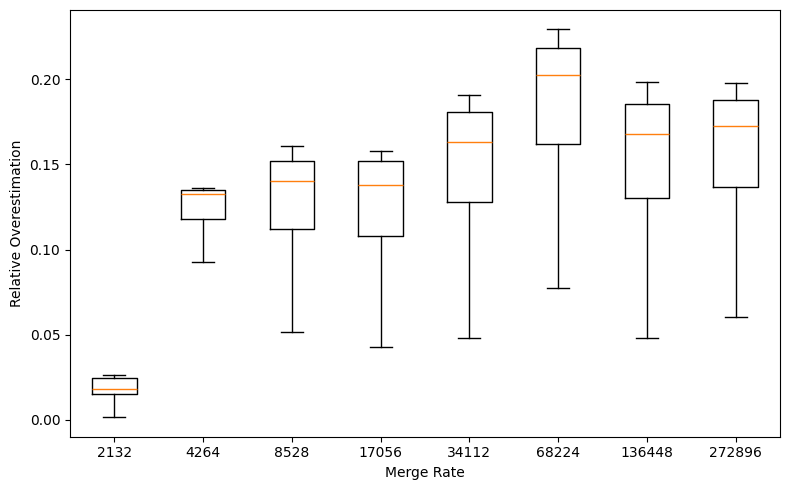

['2132', '4264', '8528', '17056', '34112', '68224', '136448', '272896']


In [ ]:
plt.figure(figsize=(8, 5))

data = []
labels = []
mean_errors = []

for errors in rel_errors_list:
    rank1_errors = errors[errors["rank"] == 1]
    merge_rate = errors["mergeRate"].iloc[0]
    values = rank1_errors["rel_error"]
    mean_errors.append(values.mean())
    print("Mean relative error for merge rate", merge_rate, ":", values.mean())
    
    data.append(values)
    labels.append(merge_rate)

print(min(mean_errors) , max(mean_errors))

    #inverse logarithmic scale for x-axis
plt.boxplot(data, labels=labels, showfliers=False)
plt.xlabel("Merge Rate")
plt.ylabel("Relative Overestimation")
plt.tight_layout()
plt.show()


print(labels)



0.00041788435216113493
0.16104816954725099


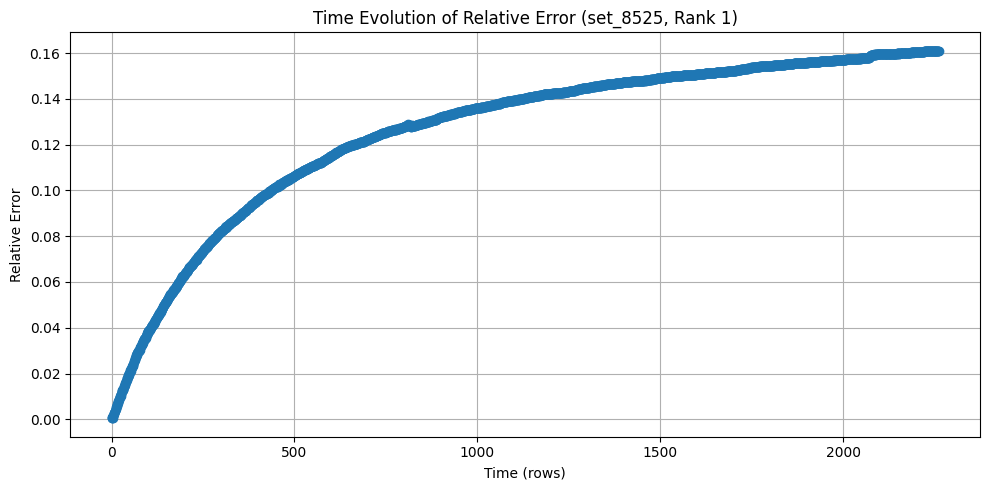

In [213]:
plt.figure(figsize=(10, 5))

# Assuming set_8528 is the first dataset in rel_errors_list
errors_8528 = rel_errors_list[2]  

# Filter for rank 1
rank1_errors = errors_8528[errors_8528["rank"] == 1]

print(min(rank1_errors["rel_error"]))   
print(max(rank1_errors["rel_error"])) 
# Plot relative error over time (rows)
plt.plot(rank1_errors.index, rank1_errors["rel_error"], marker='o', linestyle='-')

plt.xlabel("Time (rows)")
plt.ylabel("Relative Error")
plt.title("Time Evolution of Relative Error (set_8525, Rank 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

